In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam

Using TensorFlow backend.


## Utility Functions

In [0]:
def plot_autoencoder_outputs(autoencoder, n, dims):
  
  decoded_imgs = autoencoder.predict(x_test)
  
  # number of example digits to show
  n = 5
  plt.figure(figsize = (10, 4.5))
  for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(*dims))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
      ax.set_title('Original Images')
      
    # plot reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(*dims))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
      ax.set_title('Reconstructed Images')
  plt.show()

In [0]:
def plot_loss(history):
  
  historydf = pd.DataFrame(history.history, 
                           index = history.epoch)
  plt.figure(figsize = (8, 6))
  historydf.plot(ylim = (0, historydf.values.max()))
  plt.title('Loss: %.3f' % history.history['loss'][-1])

In [0]:
def plot_compare_histories(history_list, name_list, plot_accuracy = True):
  
  dflist = []
  min_epoch = len(history_list[0].epoch)
  losses = []
  
  for history in history_list:
    h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
    dflist.append(pd.DataFrame(h, index = history.epoch))
    min_epoch = min(min_epoch, len(history.epoch))
    losses.append(h['loss'][-1])
  
  historydf = pd.concat(dflist, axis = 1)
  
  metrics = dflist[0].columns
  
  idx = pd.MultiIndex.from_product([name_list, metrics],
                                   names = ['model', 'metric'])
  
  historydf.columns = idx
  
  plt.figure(figsize = (6, 8))
  
  ax = plt.subplot(211)
  
  historydf.xs('loss', axis = 1, level = 'metric').plot(ylim = (0, 1), 
                                                        ax = ax)
  
  plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
  
  if plot_accuracy:
    ax = plt.subplot(212)
    historydf.xs('acc', axis = 1, level = 'metric').plot(ylim = (0, 1), ax = ax)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    
  plt.xlim(0, min_epoch - 1)
  plt.tight_layout()

# MNIST

## Deep Autoencoder

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1: ])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 784)
(10000, 784)


In [6]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape = (input_size, ))
hidden_1 = Dense(hidden_size, activation = 'relu')(input_img)
code = Dense(code_size, activation = 'relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation = 'relu')(code)
output_img = Dense(input_size, activation = 'sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer = 'adam',
                    loss = 'binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs = 3)

W0806 19:57:44.322441 140219543541632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 19:57:44.367660 140219543541632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 19:57:44.374321 140219543541632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 19:57:44.422386 140219543541632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0806 19:57:44.442774 140219543541632 deprecation_wrappe

Epoch 1/3
60000/60000 [==============================] - 10s 170us/step - loss: 0.1377
Epoch 2/3
60000/60000 [==============================] - 7s 109us/step - loss: 0.0996
Epoch 3/3
60000/60000 [==============================] - 6s 107us/step - loss: 0.0942


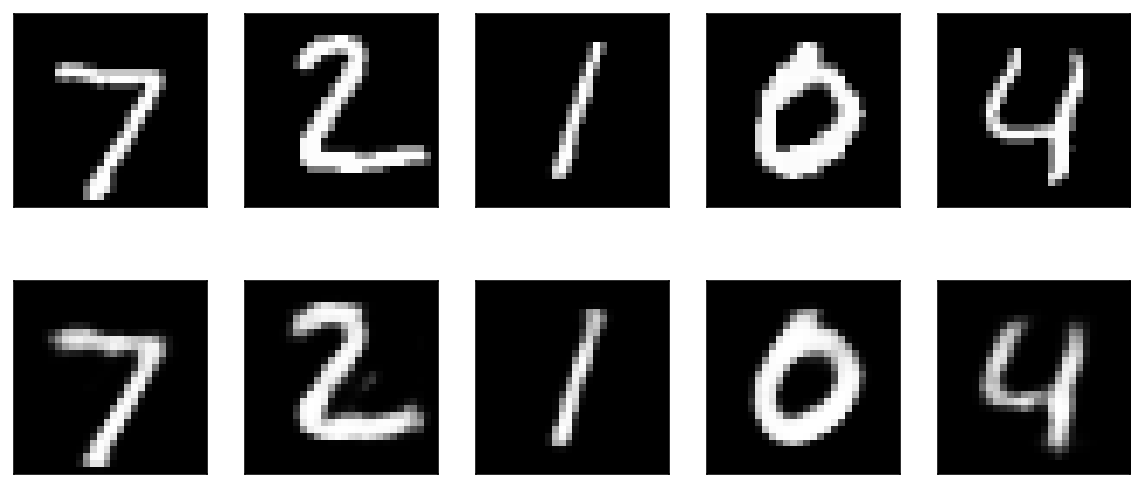

In [7]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

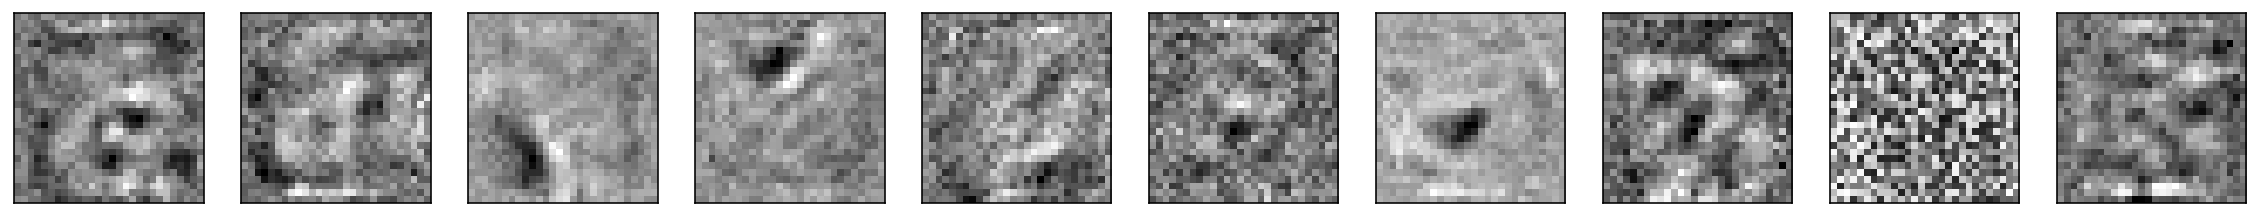

In [8]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize = (20, 5))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(weights[i + 0].reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

## Shallow Autoencoder

In [9]:
input_size = 784
code_size = 32

input_img = Input(shape = (input_size, ))
code = Dense(code_size, activation = 'relu')(input_img)
output_img = Dense(input_size, activation = 'sigmoid')(code)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer = 'adam',
                    loss = 'binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs = 5)

Epoch 1/5
60000/60000 [==============================] - 5s 91us/step - loss: 0.1625
Epoch 2/5
60000/60000 [==============================] - 5s 87us/step - loss: 0.1045
Epoch 3/5
60000/60000 [==============================] - 5s 88us/step - loss: 0.0967
Epoch 4/5
60000/60000 [==============================] - 5s 88us/step - loss: 0.0953
Epoch 5/5
60000/60000 [==============================] - 5s 86us/step - loss: 0.0947


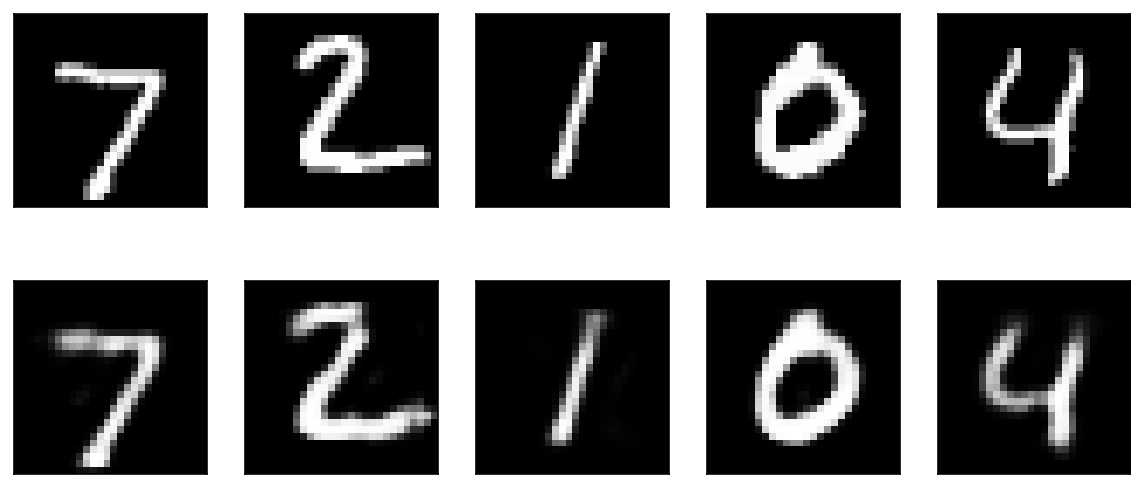

In [10]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

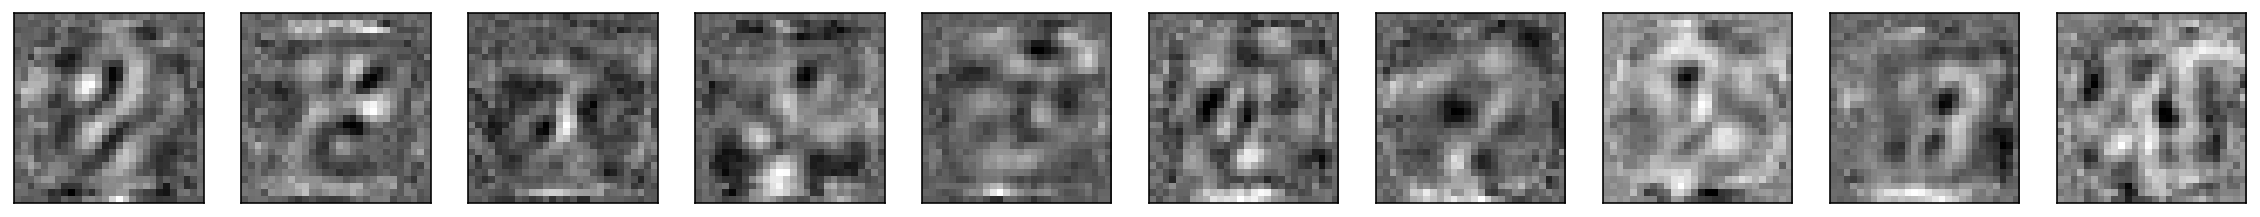

In [11]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize = (20, 5))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(weights[i + 20].reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

## Denoising Autoencoder

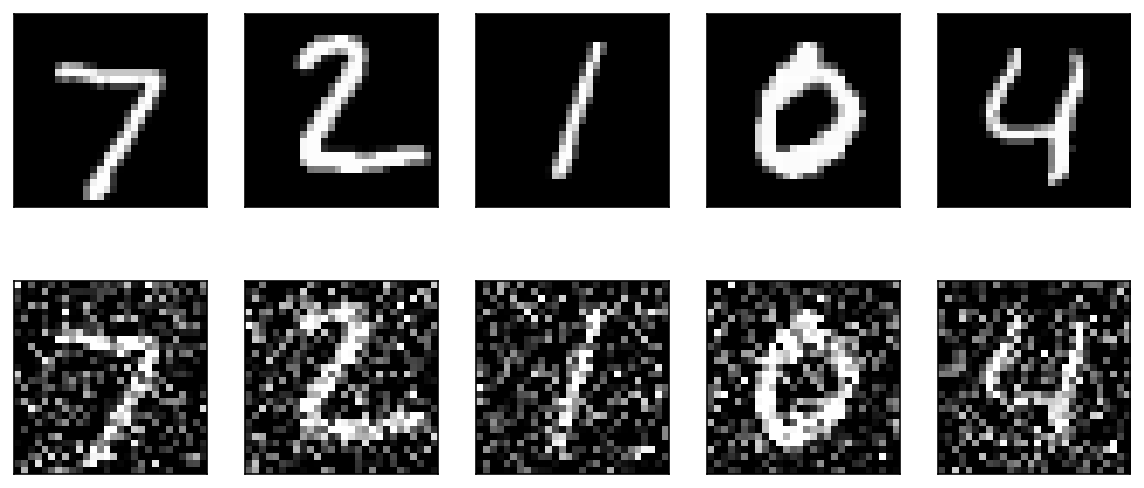

In [12]:
noise_factor = 0.4

x_train_noisy = x_train + noise_factor * np.random.normal(size = x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size = x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

n = 5
plt.figure(figsize = (10, 4.5))
for i in range(n):
  # plot original image
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == n/2:
    ax.set_title('Original Images')
    
  # plot noisy image
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(x_test_noisy[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == n/2:
    ax.set_title('Noisy Input')

In [13]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape = (input_size, ))
hidden_1 = Dense(hidden_size, activation = 'relu')(input_img)
code = Dense(code_size, activation = 'relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation = 'relu')(code)
output_img = Dense(input_size, activation = 'sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer = 'Adam',
                    loss = 'binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train, epochs = 10)

Epoch 1/10
60000/60000 [==============================] - 7s 118us/step - loss: 0.1617
Epoch 2/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.1257
Epoch 3/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.1194
Epoch 4/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.1165
Epoch 5/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.1146
Epoch 6/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.1132
Epoch 7/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.1122
Epoch 8/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.1113
Epoch 9/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.1106
Epoch 10/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.1100


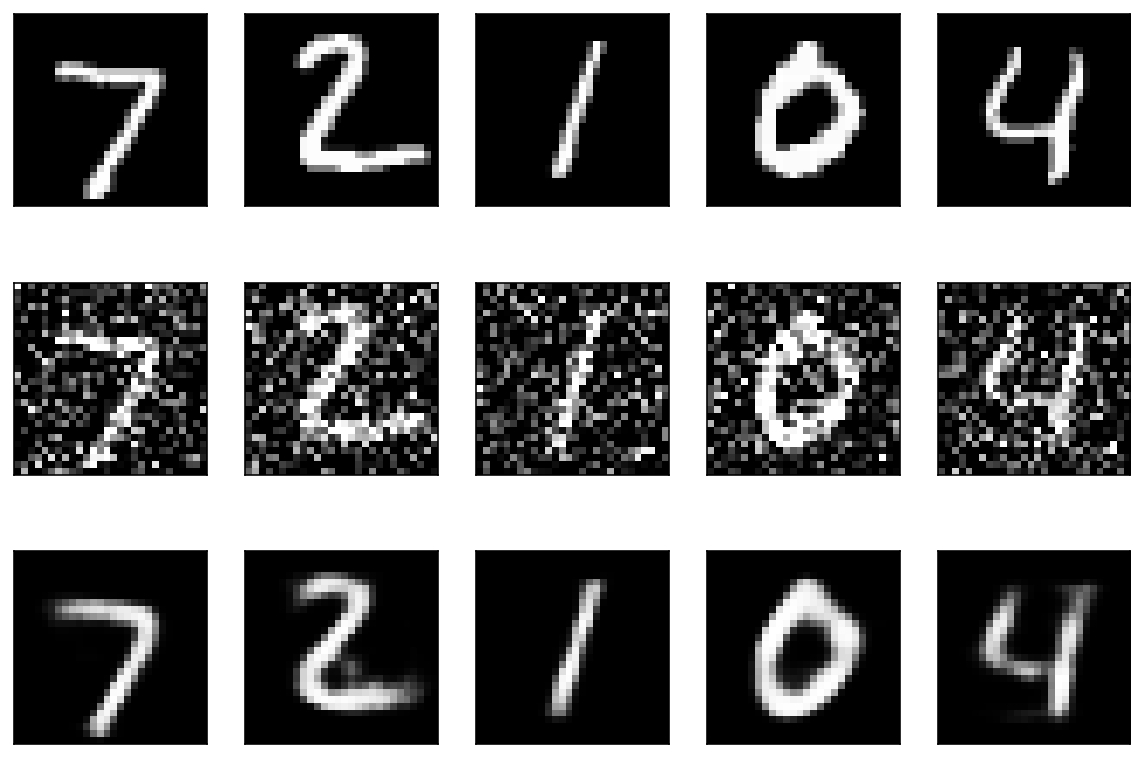

In [14]:
n = 5
plt.figure(figsize = (10, 7))

images = autoencoder.predict(x_test_noisy)

for i in range(n):
  # plot original image
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == n/2:
    ax.set_title('Original Images')
    
  # plot noisy image
  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(x_test_noisy[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == n/2:
    ax.set_title('Noisy Input')
    
  # plot output image
  ax = plt.subplot(3, n, i + 1 + 2*n)
  plt.imshow(images[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == n/2:
    ax.set_title('Autoencoder Output')

## Sparse AutoEncoders

In [15]:
input_size = 784
code_size = 32

input_img = Input(shape = (input_size, ))
code = Dense(code_size, activation = 'relu')(input_img)
output_img = Dense(input_size, activation = 'sigmoid')(code)

autoencoder_standard = Model(input_img, output_img)
autoencoder_standard.compile(optimizer = 'adam',
                             loss = 'binary_crossentropy')
history_standard = autoencoder_standard.fit(x_train, x_train,
                                            epochs = 20)

encoded_standard = Model(input_img, code)

Epoch 1/20
60000/60000 [==============================] - 6s 96us/step - loss: 0.1623
Epoch 2/20
60000/60000 [==============================] - 5s 90us/step - loss: 0.1046
Epoch 3/20
60000/60000 [==============================] - 5s 90us/step - loss: 0.0965
Epoch 4/20
60000/60000 [==============================] - 5s 90us/step - loss: 0.0951
Epoch 5/20
60000/60000 [==============================] - 5s 90us/step - loss: 0.0946
Epoch 6/20
60000/60000 [==============================] - 5s 90us/step - loss: 0.0943
Epoch 7/20
60000/60000 [==============================] - 5s 91us/step - loss: 0.0941
Epoch 8/20
60000/60000 [==============================] - 5s 91us/step - loss: 0.0940
Epoch 9/20
60000/60000 [==============================] - 5s 90us/step - loss: 0.0939
Epoch 10/20
60000/60000 [==============================] - 5s 90us/step - loss: 0.0938
Epoch 11/20
60000/60000 [==============================] - 5s 90us/step - loss: 0.0937
Epoch 12/20
60000/60000 [===========================

In [16]:
input_size = 784
code_size = 32

input_img = Input(shape = (input_size, ))
code = Dense(code_size, activation = 'relu',
             activity_regularizer = l1(10e-6))(input_img)
output_img = Dense(input_size, activation = 'sigmoid')(code)

autoencoder_regularized = Model(input_img, output_img)
autoencoder_regularized.compile(optimizer = 'Adam',
                                loss = 'binary_crossentropy')
history_regularized = autoencoder_regularized.fit(x_train, x_train,
                                                  epochs = 20)

encoded_regularized = Model(input_img, code)

Epoch 1/20
60000/60000 [==============================] - 6s 93us/step - loss: 0.1814
Epoch 2/20
60000/60000 [==============================] - 5s 89us/step - loss: 0.1278
Epoch 3/20
60000/60000 [==============================] - 5s 88us/step - loss: 0.1182
Epoch 4/20
60000/60000 [==============================] - 5s 89us/step - loss: 0.1143
Epoch 5/20
60000/60000 [==============================] - 5s 89us/step - loss: 0.1120
Epoch 6/20
60000/60000 [==============================] - 5s 88us/step - loss: 0.1103
Epoch 7/20
60000/60000 [==============================] - 5s 88us/step - loss: 0.1091
Epoch 8/20
60000/60000 [==============================] - 5s 88us/step - loss: 0.1081
Epoch 9/20
60000/60000 [==============================] - 5s 91us/step - loss: 0.1073
Epoch 10/20
60000/60000 [==============================] - 6s 94us/step - loss: 0.1066
Epoch 11/20
60000/60000 [==============================] - 5s 91us/step - loss: 0.1061
Epoch 12/20
60000/60000 [===========================

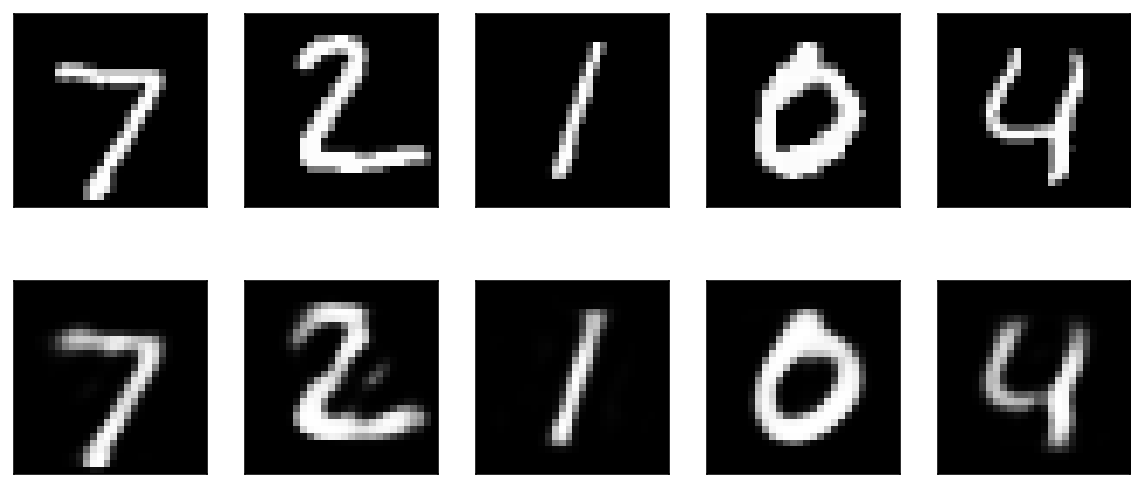

In [17]:
plot_autoencoder_outputs(autoencoder_regularized, 5, (28, 28))

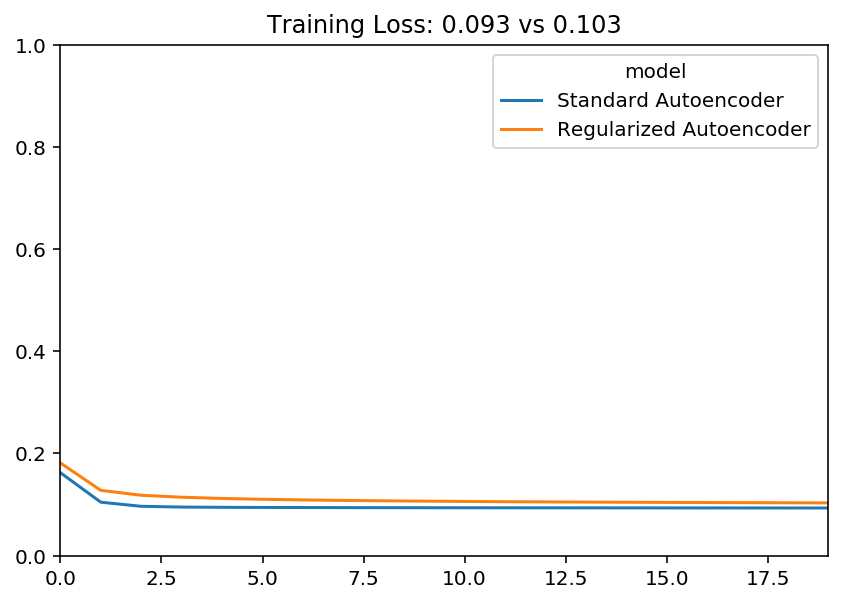

In [18]:
plot_compare_histories([history_standard, history_regularized],
                       ['Standard Autoencoder', 'Regularized Autoencoder'],
                       plot_accuracy = False)

In [19]:
autoencoder_standard.evaluate(x_test, x_test)

10000/10000 [==============================] - 0s 48us/step


0.09206121373176575

In [20]:
autoencoder_regularized.evaluate(x_test, x_test)

10000/10000 [==============================] - 0s 47us/step


0.10183090069293976

In [21]:
print(encoded_standard.predict(x_test).mean())
print(encoded_regularized.predict(x_test).mean())

6.611961
0.76977706


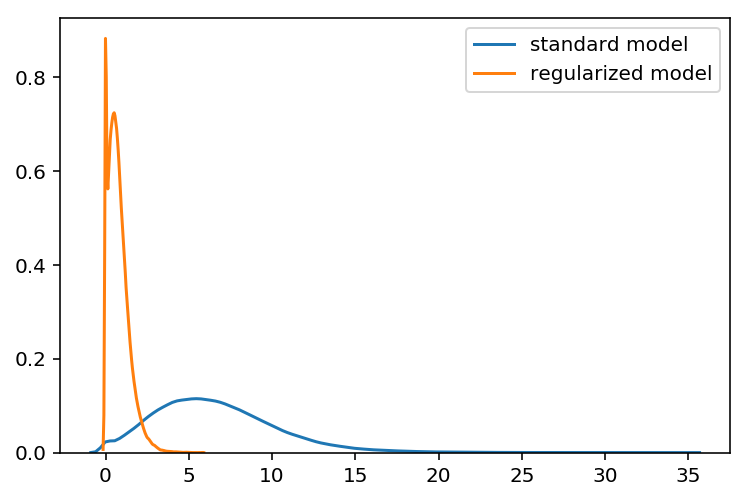

In [22]:
standard_scores = encoded_standard.predict(x_test).ravel()
regularized_scores = encoded_regularized.predict(x_test).ravel()

sns.distplot(standard_scores, hist = False, 
             label = 'standard model')

sns.distplot(regularized_scores, hist = False,
             label = 'regularized model')

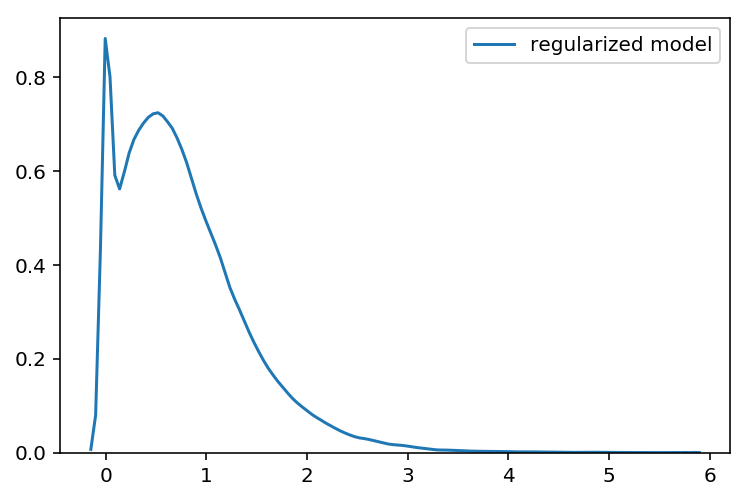

In [23]:
sns.distplot(regularized_scores, hist = False,
            label = 'regularized model')